In [1]:
# Copyright 2025 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" align="right" width="100px"/>

# Nemotron Parse: From Complex Documents to Agent-Ready Data

NVIDIA Nemotron Parse (also known as NeMo Retriever Parse) is a transformer-based VLM specialized for document parsing. Think of it as the ingestion backbone for your AI agent. Its job is to:
- Accurately extract text and formulas in correct reading order.
- Robustly parse complex tables into a structured format (like LaTeX).
- Perform semantic segmentation (labeling Title, Text, List-item, Figure, etc.).
- Provide spatial grounding (a bbox for every element).

It's built to preserve meaning and structure at scale, so your agent can act on the right information with confidence.
![image](https://i.imgur.com/pYLFOAd.png)

---

### What you’ll learn in this notebook:
* How to call Nemotron Parse on a PDF page image and get structured JSON.
* How to visualize the model's layout understanding.
* How to convert the model's output (including complex tables) into clean HTML and Markdown for RAG or agentic workflows.
* How this model complements a separate visual reasoning model in a full document AI agent.

Note: This notebook focuses only on Nemotron Parse. Its job is to find what elements are on the page and where they are. If your workflow also needs to understand the visual content inside a Picture or Figure block (e.g., analyze a chart, describe a photo), you would pair Parse with a visual reasoning model in a second stage.

Parse tells you where the image is; a reasoning model tells you what the image means.

## 0. Setup

Install minimal dependencies for PDF rendering (PyMuPDF), API calls (requests), and visualization (Pillow).

In [ ]:
%pip install --quiet requests pillow pymupdf pandas markdown bleach

### Configure API Endpoint

This notebook uses the call_nemotron_parse function to call the NVIDIA API-compatible endpoint via the Chat Completions API.

Requirements:
1) Set your NVIDIA_API_KEY as an environment variable.
2) Optionally set NVAI_URL to your NVIDIA API Gateway or local NIM gateway.

The model returns a list of layout blocks with:
- type: e.g., "Title", "Text", "List-item", "Table", etc.
- text: the block's textual content (for tables, a LaTeX tabular string)
- bbox: normalized coordinates {xmin, ymin, xmax, ymax} in [0,1]

In [2]:
import os
import re
import json
import base64
import requests
import fitz  # PyMuPDF
from typing import List, Dict, Any, Tuple
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO
import pandas as pd
from IPython.display import display, Markdown, HTML

# API configuration
API_KEY = os.environ.get("NVIDIA_API_KEY", "YOUR_API_KEY_HERE")
NVAI_URL = os.environ.get("NVAI_URL", "http://localhost:8002/v1")

if API_KEY == "YOUR_API_KEY_HERE":
    print("WARNING: NVIDIA_API_KEY not set. Please set it to run the notebook.")

# Output directory for artifacts
OUTPUT_DIR = "parse_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Using API URL: {NVAI_URL}")
print(f"Output directory: {os.path.abspath(OUTPUT_DIR)}")

# Class color mapping for visualization
CLASS_COLORS = {
    'Title': '#D32F2F',
    'Section-header': '#E91E63',
    'Text': '#4CAF50',
    'List-item': '#1976D2',
    'Caption': '#607D8B',
    'Table': '#03A9F4',
    'Figure': '#6D4C41',
    'Picture': '#6D4C41',
    'Formula': '#FF9800',
    'Page-header': '#9E9E9E',
    'Page-footer': '#9E9E9E',
    'Footnote': '#00BCD4',
    'Bibliography': '#512DA8',
    'TOC': '#FFC107',
    'DEFAULT': '#9E9E9E'
}

def get_text_color(hex_color: str) -> str:
    """Return black or white for best contrast over a hex background color."""
    hex_color = hex_color.lstrip('#')
    r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    luminance = (0.2126 * r + 0.7152 * g + 0.0722 * b)
    return "#000000" if luminance > 140 else "#FFFFFF"

Using API URL: http://localhost:8002/v1
Output directory: /home/ubuntu/nim-dev/models/nemotron-parse-prod/parse_outputs


## 1. Helper Functions

Helpers for:
1) PDF-to-Image rendering.
2) API call via Chat Completions.
3) Visualization.
4) LaTeX tables to HTML and page-to-Markdown assembly.

In [3]:
from markdown import markdown
import bleach

# PDF page rendering
def pdf_page_to_image(pdf_path: str, page_index: int, dpi: int = 300,
                      target_size: Tuple[int, int] = (1536, 2048)) -> Image.Image:
    """Render a PDF page to an RGB image and center it on a fixed-size canvas."""
    doc = fitz.open(pdf_path)
    page = doc.load_page(page_index)
    zoom = dpi / 72.0
    pix = page.get_pixmap(matrix=fitz.Matrix(zoom, zoom))
    src = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    doc.close()

    canvas = Image.new("RGB", target_size, (255, 255, 255))
    src.thumbnail(target_size, Image.Resampling.LANCZOS)
    x = (target_size[0] - src.width) // 2
    y = (target_size[1] - src.height) // 2
    canvas.paste(src, (x, y))
    return canvas

# Image encoding
def encode_image_to_base64(image: Image.Image, fmt: str = "PNG") -> str:
    """Encode a PIL image to base64 for API submission."""
    buf = BytesIO()
    image.save(buf, format=fmt)
    return base64.b64encode(buf.getvalue()).decode('utf-8')

# Nemotron Parse API call
def call_nemotron_parse(base64_image: str) -> List[Dict[str, Any]]:
    """Call the nemotron-parse model and return a list of blocks with type/text/bbox."""
    headers = {"Authorization": f"Bearer {API_KEY}", "Accept": "application/json"}
    messages = [{
        "role": "user",
        "content": [{
            "type": "image_url",
            "image_url": {"url": f"data:image/png;base64,{base64_image}"}
        }]
    }]
    tools = [{"type": "function", "function": {"name": "markdown_bbox"}}]
    payload = {
        "model": "nvidia/nemotron-parse",
        "messages": messages,
        "max_tokens": 3500,
        "temperature": 0,
        "tools": tools
    }
    try:
        resp = requests.post(f"{NVAI_URL}/chat/completions", headers=headers, json=payload, timeout=180)
        resp.raise_for_status()
        response_json = resp.json()
    except requests.exceptions.HTTPError as e:
        print(f"API Error for nvidia/nemotron-parse: {e.response.status_code} - {e.response.text}")
        return []
    except Exception as e:
        print(f"Unexpected error calling nemotron-parse: {e}")
        return []

    tool_call = response_json.get("choices", [{}])[0].get("message", {}).get("tool_calls", [{}])[0]
    if not tool_call:
        return []
    arguments_str = tool_call.get("function", {}).get("arguments", "[]")
    try:
        parsed_args = json.loads(arguments_str)
        if isinstance(parsed_args, list) and len(parsed_args) > 0 and isinstance(parsed_args[0], list):
            return parsed_args[0]
        return parsed_args if isinstance(parsed_args, list) else []
    except json.JSONDecodeError:
        print(f"Error decoding JSON from arguments: {arguments_str}")
        return []

# Visualization
def draw_layout(image: Image.Image, blocks: List[Dict[str, Any]]) -> Image.Image:
    """Draw bounding boxes and labels for each parsed block."""
    out = image.copy()
    draw = ImageDraw.Draw(out)
    W, H = out.size
    box_thickness = max(2, int(W / 600))
    font_size = max(14, int(W / 80))
    try:
        font = ImageFont.truetype("Arial.ttf", font_size)
    except Exception:
        font = ImageFont.load_default()

    for i, b in enumerate(blocks):
        bbox = b.get("bbox") or {}
        xmin, ymin = bbox.get("xmin", 0.0), bbox.get("ymin", 0.0)
        xmax, ymax = bbox.get("xmax", 0.0), bbox.get("ymax", 0.0)
        if xmax <= xmin or ymax <= ymin:
            continue
        x0, y0, x1, y1 = xmin * W, ymin * H, xmax * W, ymax * H
        cat = b.get("type", "DEFAULT")
        color = CLASS_COLORS.get(cat, CLASS_COLORS["DEFAULT"])
        text_color = get_text_color(color)
        draw.rectangle([x0, y0, x1, y1], outline=color, width=box_thickness)
        label = f"{i}:{cat}"
        try:
            tb = draw.textbbox((0, 0), label, font=font)
            tw, th = tb[2] - tb[0], tb[3] - tb[1]
        except Exception:
            tw, th = draw.textsize(label, font=font)
        label_bg = (x0, max(0, y0 - th - 6), x0 + tw + 8, max(0, y0 - 6))
        draw.rectangle(label_bg, fill=color)
        draw.text((label_bg[0] + 4, label_bg[1] + 2), label, fill=text_color, font=font)
    return out

# Records and DataFrame
def blocks_to_dataframe(blocks: List[Dict[str, Any]]) -> pd.DataFrame:
    rows = []
    for i, b in enumerate(blocks):
        txt = (b.get("text") or "").replace("\n", " ")
        rows.append({
            "id": i,
            "type": b.get("type"),
            "text": txt[:200],
            "bbox": b.get("bbox")
        })
    return pd.DataFrame(rows)

def blocks_to_records(blocks: List[Dict[str, Any]], page_number: int, page_size_px: Tuple[int, int]) -> List[Dict[str, Any]]:
    W, H = page_size_px
    records = []
    for i, b in enumerate(blocks):
        bbox = b.get("bbox") or {"xmin": 0, "ymin": 0, "xmax": 0, "ymax": 0}
        x0, y0 = int(bbox.get("xmin", 0) * W), int(bbox.get("ymin", 0) * H)
        x1, y1 = int(bbox.get("xmax", 0) * W), int(bbox.get("ymax", 0) * H)
        records.append({
            "page": page_number,
            "id": i,
            "type": b.get("type"),
            "text": b.get("text"),
            "bbox_norm": bbox,
            "bbox_px": [x0, y0, x1, y1]
        })
    return records

# LaTeX table parsing
def _clean_latex_text(s: str) -> str:
    s = s.strip()
    s = re.sub(r"\\textbf\{(.*?)\}", r"<b>\1</b>", s)
    s = re.sub(r"\\textit\{(.*?)\}", r"<i>\1</i>", s)
    replacements = {
        r"\$": "$",
        r"\%": "%",
        r"\\&": "&",
        r"\\_": "_",
        r"\\#": "#",
        r"\\textless": "<",
        r"\\textgreater": ">",
        r"\\newline": " "
    }
    for k, v in replacements.items():
        s = re.sub(k, v, s)
    return s

def _parse_cell_spans(cell: str) -> Tuple[str, int, int]:
    """Parse a cell for \multicolumn and \multirow; return (content, colspan, rowspan)."""
    content = cell.strip()
    colspan, rowspan = 1, 1
    changed = True
    while changed:
        changed = False
        m = re.match(r"\\multicolumn\{(\d+)\}\{[^}]*\}\{(.*)\}\s*$", content, flags=re.DOTALL)
        if m:
            colspan = int(m.group(1))
            content = m.group(2).strip()
            changed = True
            continue
        m = re.match(r"\\multirow\{(\d+)\}\{[^}]*\}\{(.*)\}\s*$", content, flags=re.DOTALL)
        if m:
            rowspan = int(m.group(1))
            content = m.group(2).strip()
            changed = True
            continue
    content = _clean_latex_text(content)
    return content, colspan, rowspan

def latex_table_to_html(latex_str: str) -> str:
    """Convert a LaTeX tabular into HTML. Fallbacks to raw pre if parsing fails."""
    try:
        if not latex_str:
            return ""
        m = re.search(r"\\begin\{tabular\}\{[^}]*\}(.*?)\\end\{tabular\}", latex_str, flags=re.DOTALL)
        content = m.group(1) if m else latex_str
        content = re.sub(r"\\hline", "", content)
        rows_raw = [r.strip() for r in re.split(r"(?<!\\)\\\\", content) if r.strip()]
        if not rows_raw:
            return f"<pre><code>{latex_str}</code></pre>"

        occupied = set()
        table_rows = []
        for r_idx, row_str in enumerate(rows_raw):
            parts = [p.strip() for p in re.split(r"(?<!\\)&", row_str) if p.strip()]
            if not parts:
                continue
            current_row = []
            col = 0
            for cell_str in parts:
                while (r_idx, col) in occupied:
                    col += 1
                content_cell, colspan, rowspan = _parse_cell_spans(cell_str)
                current_row.append({
                    "content": content_cell,
                    "col": col,
                    "colspan": max(1, int(colspan)),
                    "rowspan": max(1, int(rowspan))
                })
                for dr in range(1, int(rowspan)):
                    for dc in range(0, int(colspan)):
                        occupied.add((r_idx + dr, col + dc))
                col += int(colspan)
            table_rows.append(current_row)

        html = ["<table border=\"1\" class=\"dataframe\">"]
        for r_idx, cells in enumerate(table_rows):
            html.append("  <tr>")
            tag = 'th' if r_idx == 0 else 'td'
            for cell in cells:
                attrs = []
                if cell["colspan"] > 1:
                    attrs.append(f"colspan=\"{cell['colspan']}\"")
                if cell["rowspan"] > 1:
                    attrs.append(f"rowspan=\"{cell['rowspan']}\"")
                attr_str = (" " + " ".join(attrs)) if attrs else ""
                html.append(f"    <{tag}{attr_str}>{cell['content']}</{tag}>")
            html.append("  </tr>")
        html.append("</table>")
        return "\n".join(html)
    except Exception as e:
        print(f"Warning: Could not parse LaTeX table. Returning raw. Error: {e}")
        return f"<pre><code>{latex_str}</code></pre>"

# Markdown assembly and rendering
def clean_md(text: str) -> str:
    text = re.sub(r'\\([#>*_`~\-+\!\[\]\(\)])', r'\1', text)
    text = text.replace('•', '-')
    return text.strip()

def blocks_to_markdown_page(blocks: List[Dict[str, Any]]) -> str:
    """Build a Markdown string for the page. Tables are injected as raw HTML."""
    md_lines = []
    in_list = False
    for b in blocks:
        cat = b.get("type", "Text")
        text = (b.get("text") or "").strip()
        if not text:
            continue

        if cat == "Table":
            if in_list:
                md_lines.append("")
                in_list = False
            html_tbl = latex_table_to_html(text)
            md_lines.append(html_tbl)
            md_lines.append("")
            continue

        if cat == "Formula":
            if in_list:
                md_lines.append("")
                in_list = False
            md_lines.append(f"<pre><code>$$ {text} $$</code></pre>")
            md_lines.append("")
            continue

        t = clean_md(text)

        if cat == "Title":
            line = t if t.lstrip().startswith("#") else f"# {t}"
            if in_list:
                md_lines.append("")
                in_list = False
            md_lines.append(line)
            md_lines.append("")
            continue

        if cat == "Section-header":
            line = t if t.lstrip().startswith("##") else f"## {t}"
            if in_list:
                md_lines.append("")
                in_list = False
            md_lines.append(line)
            md_lines.append("")
            continue

        if cat == "List-item":
            md_lines.append(f"- {t}")
            in_list = True
            continue

        if cat == "Caption":
            if in_list:
                md_lines.append("")
                in_list = False
            md_lines.append(f"> Caption: {t}")
            md_lines.append("")
            continue

        if cat == "Footnote":
            if in_list:
                md_lines.append("")
                in_list = False
            md_lines.append(f"<p><small>[Footnote] {t}</small></p>")
            md_lines.append("")
            continue

        md_lines.append(t)
        md_lines.append("")

    if in_list:
        md_lines.append("")
    return "\n".join(md_lines).strip()

def render_markdown_to_html(md_text: str) -> str:
    """Render Markdown to HTML, then sanitize while allowing table-related tags."""
    html = markdown(md_text, extensions=["extra", "sane_lists"])
    allowed_tags = [
        "h1","h2","h3","h4","h5","h6","p","em","strong","code","pre","blockquote","br",
        "ul","ol","li",
        "table","thead","tbody","tr","th","td"
    ]
    allowed_attrs = {"table": ["border", "class"], "td": ["colspan","rowspan"], "th": ["colspan","rowspan"]}
    return bleach.clean(html, tags=allowed_tags, attributes=allowed_attrs, strip=True)

<>:157: SyntaxWarning: invalid escape sequence '\m'
<>:157: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_8421/1123401756.py:157: SyntaxWarning: invalid escape sequence '\m'
  """Parse a cell for \multicolumn and \multirow; return (content, colspan, rowspan)."""


## 2. Quickstart: Parse a Sample PDF

We’ll fetch a PDF that mixes text, a table, headers, lists, and a footnote. For each page, we will:
1) Render the page as an image.
2) Call Nemotron Parse.
3) Visualize the detected layout blocks.
4) Inspect the extracted data in a DataFrame.
5) Export the full data to a JSONL file for downstream use.

PDF saved to: parse_outputs/corporate-nvidia-in-brief.pdf


--- 
### Processing Page 1...

#### Page 1 — Annotated Layout

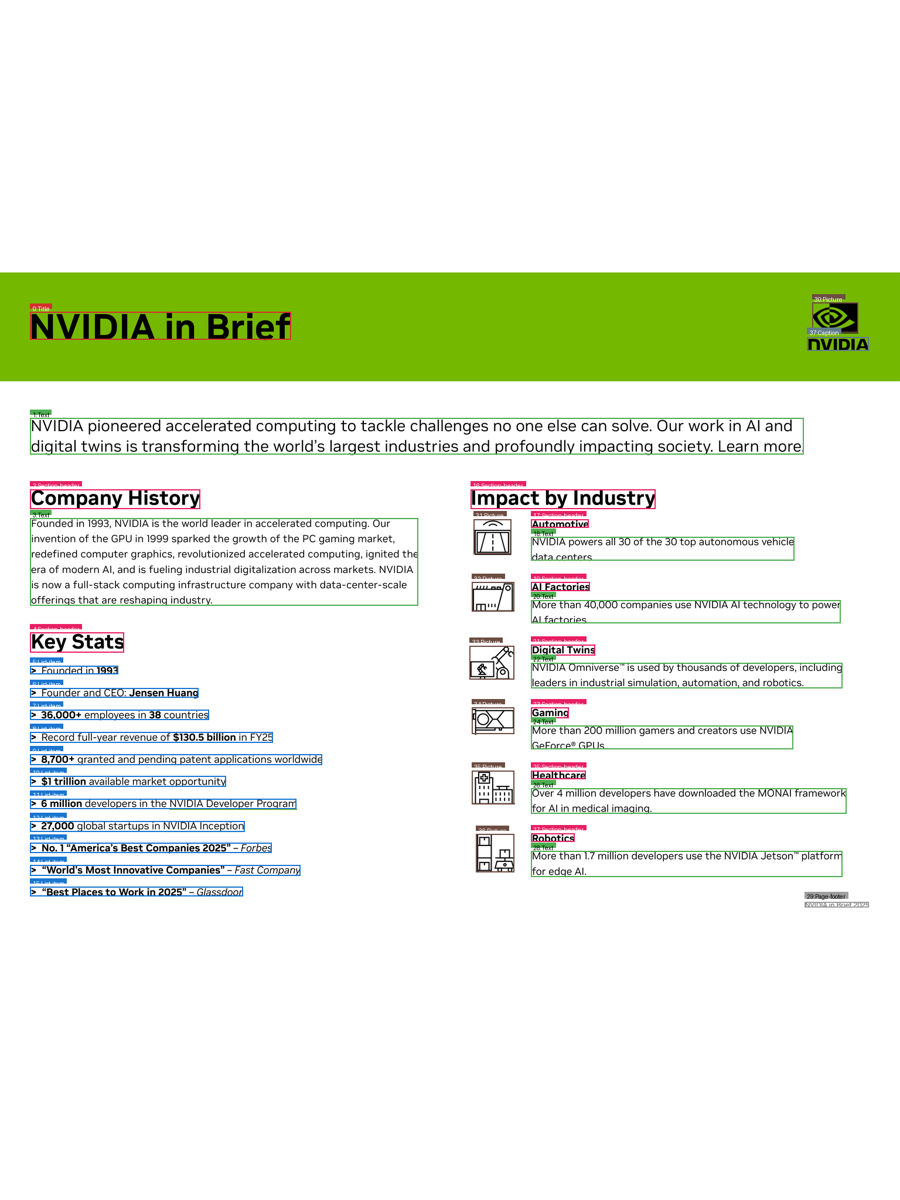

Top blocks (id, type, text preview):

,id,type,text,bbox
0,0,Title,NVIDIA in Brief,"{'xmin': 0.033710416666666666, 'ymin': 0.2602,..."
1,1,Text,NVIDIA pioneered accelerated computing to tack...,"{'xmin': 0.033710416666666666, 'ymin': 0.3484,..."
2,2,Section-header,## Company History,"{'xmin': 0.033710416666666666, 'ymin': 0.4078,..."
3,3,Text,"Founded in 1993, NVIDIA is the world leader in...","{'xmin': 0.033710416666666666, 'ymin': 0.432, ..."
4,4,Section-header,## Key Stats,"{'xmin': 0.033710416666666666, 'ymin': 0.5273,..."
5,5,List-item,\>\> Founded in 1993,"{'xmin': 0.033710416666666666, 'ymin': 0.5547,..."
6,6,List-item,\>\> Founder and CEO: **Jensen Huang**,"{'xmin': 0.033710416666666666, 'ymin': 0.5734,..."
7,7,List-item,"\>\> 36,000+ employees in 38 countries","{'xmin': 0.033710416666666666, 'ymin': 0.5914,..."
8,8,List-item,\>\> Record full-year revenue of $130.5 billio...,"{'xmin': 0.033710416666666666, 'ymin': 0.6102,..."
9,9,List-item,"\>\> 8,700+ granted and pending patent applica...","{'xmin': 0.033710416666666666, 'ymin': 0.6289,..."


--- 
### Processing Page 2...

#### Page 2 — Annotated Layout

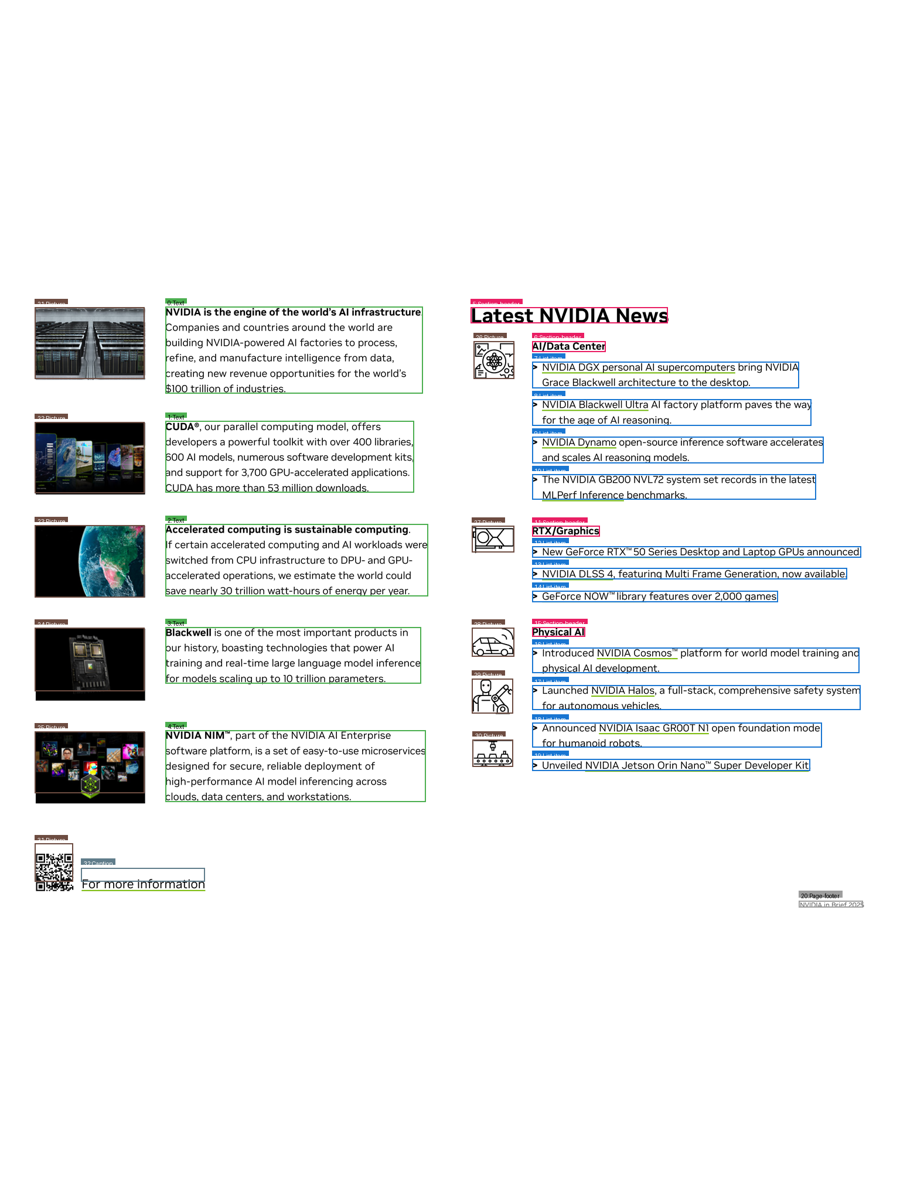

Top blocks (id, type, text preview):

,id,type,text,bbox
0,0,Text,**NVIDIA is the engine of the world’s AI infra...,"{'xmin': 0.183596875, 'ymin': 0.2555, 'xmax': ..."
1,1,Text,"**CUDA**<sup>®</sup>, our parallel computing m...","{'xmin': 0.183596875, 'ymin': 0.3508, 'xmax': ..."
2,2,Text,**Accelerated computing is sustainable computi...,"{'xmin': 0.183596875, 'ymin': 0.4367, 'xmax': ..."
3,3,Text,**Blackwell** is one of the most important pro...,"{'xmin': 0.183596875, 'ymin': 0.5227, 'xmax': ..."
4,4,Text,"**NVIDIA NIM**<sup>TM</sup>, part of the NVIDI...","{'xmin': 0.183596875, 'ymin': 0.6086, 'xmax': ..."
5,5,Section-header,# Latest NVIDIA News,"{'xmin': 0.5230677083333333, 'ymin': 0.2562, '..."
6,6,Section-header,**AI/Data Center**,"{'xmin': 0.5911979166666667, 'ymin': 0.2844, '..."
7,7,List-item,\>\> NVIDIA DGX personal AI supercomputers bri...,"{'xmin': 0.5911979166666667, 'ymin': 0.3016, '..."
8,8,List-item,\>\> NVIDIA Blackwell Ultra AI factory platfor...,"{'xmin': 0.5911979166666667, 'ymin': 0.3328, '..."
9,9,List-item,\>\> NVIDIA Dynamo open-source inference softw...,"{'xmin': 0.5911979166666667, 'ymin': 0.3641, '..."


In [4]:
# Download a sample PDF (replace with your own if desired)
pdf_url = "https://www.nvidia.com/content/dam/en-zz/Solutions/about-nvidia/corporate-nvidia-in-brief.pdf"
pdf_path = os.path.join(OUTPUT_DIR, pdf_url.split("/")[-1].split("?")[0])
if not os.path.exists(pdf_path):
    print(f"Downloading {pdf_url}...")
    r = requests.get(pdf_url, timeout=60)
    r.raise_for_status()
    with open(pdf_path, "wb") as f:
        f.write(r.content)
    print(f"PDF saved to: {pdf_path}")
else:
    print(f"Using cached PDF: {pdf_path}")

all_records: List[Dict[str, Any]] = []
page_images_and_blocks: List[Tuple[Image.Image, List[Dict[str, Any]]]] = []

# Process up to 4 pages
try:
    with fitz.open(pdf_path) as doc:
        num_pages = min(4, len(doc))
        for page_idx in range(num_pages):
            display(Markdown(f"--- \n### Processing Page {page_idx+1}..."))

            # 1) Render
            img = pdf_page_to_image(pdf_path, page_idx, dpi=300, target_size=(1536, 2048))

            # 2) Parse
            b64 = encode_image_to_base64(img)
            blocks = call_nemotron_parse(b64)
            if not blocks:
                print(f"No blocks found for page {page_idx+1}. Skipping.")
                continue
            page_images_and_blocks.append((img, blocks))

            # 3) Visualize
            annotated = draw_layout(img, blocks)
            display(Markdown(f"#### Page {page_idx+1} — Annotated Layout"))
            display(annotated.resize((900, int(900 * annotated.height / annotated.width))))

            # 4) Inspect
            df = blocks_to_dataframe(blocks)
            display(Markdown("Top blocks (id, type, text preview):"))
            display(df.head(10))

            # 5) Collect records
            all_records.extend(blocks_to_records(blocks, page_idx+1, img.size))
except Exception as e:
    print(f"An error occurred while processing the PDF: {e}")

### Export Agent-Ready Records

This JSONL file is a structured input for downstream processes. Each record includes text, semantic type, and location on the page.

In [19]:
jsonl_path = os.path.join(OUTPUT_DIR, "parsed_records.jsonl")
with open(jsonl_path, "w", encoding="utf-8") as f:
    for rec in all_records:
        f.write(json.dumps(rec, ensure_ascii=False) + "\n")
print(f"Exported {len(all_records)} records to: {jsonl_path}")
if all_records:
    print("\n--- Sample Record --- ")
    print(json.dumps(all_records[0], indent=2))
else:
    print("No records to preview.")

Exported 71 records to: parse_outputs/parsed_records.jsonl

--- Sample Record --- 
{
  "page": 1,
  "id": 0,
  "type": "Title",
  "text": "# NVIDIA in Brief",
  "bbox_norm": {
    "xmin": 0.033710416666666666,
    "ymin": 0.2602,
    "xmax": 0.32296875,
    "ymax": 0.2828
  },
  "bbox_px": [
    51,
    532,
    496,
    579
  ]
}


## 3. Creating Usable Output: From Structure to Markdown & HTML

The raw JSON is great for machines, but the real power comes from using the semantic type and text to build human-readable and RAG-friendly content.

Tables are extracted as LaTeX to preserve structure. We convert them into clean HTML.

Let's reconstruct each processed page into an HTML view with type-aware rendering.

In [20]:
for i, (img, blocks) in enumerate(page_images_and_blocks):
    page_num = i + 1
    display(Markdown(f"--- \n### Page {page_num} — Reconstructed HTML"))

    md_text = blocks_to_markdown_page(blocks)
    html_content = render_markdown_to_html(md_text)

    # Save for downstream use
    html_path = os.path.join(OUTPUT_DIR, f"page_{page_num}_reconstructed.html")
    with open(html_path, "w", encoding="utf-8") as f:
        f.write(html_content)
    print(f"Saved reconstructed page to: {html_path}")

    # Display in the notebook
    display(HTML(f"<div style='border: 1px solid #ccc; padding: 16px; border-radius: 8px;'>{html_content}</div>"))

--- 
### Page 1 — Reconstructed HTML

Saved reconstructed page to: parse_outputs/page_1_reconstructed.html


--- 
### Page 2 — Reconstructed HTML

Saved reconstructed page to: parse_outputs/page_2_reconstructed.html


## 4. Conclusion: The Foundation for AI Agents

As we've seen, Nemotron Parse is far more than just OCR. It's a foundational document-to-structure engine. Specifically,
- 9K context = cross‑page coherence
- Industry‑leading table accuracy
- Structured, layout‑aware output with bboxes

It solves the first-mile problem of document AI by transforming messy, complex files into a clean, structured, and spatially-aware format.

This structured output is the essential first step for any advanced AI workflow:
1) Smarter RAG: Chunk documents by semantic meaning (e.g., index Text blocks and Table HTML, ignore Page-footers) to improve retrieval accuracy.
2) Building AI Agents: An agent can read the JSON and decide:
   - "Summarize the Text blocks."
   - "Extract key numbers from the Table's HTML."
   - "There is a Figure at [bbox]; send its crop to a visual reasoning model."

Nemotron Parse provides the what and where (what is this element, and where is it?). Pair it with visual reasoners to provide the why and meaning for non-text elements.

Together, they form a complementary stack for building agents that can understand and act on all parts of your documents.